In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision.transforms import transforms
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import PolynomialLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from google.colab import userdata
from tqdm import tqdm

## Datasets

[ADE20K](https://www.kaggle.com/datasets/ipythonx/ade20k-scene-parsing)
- Image : jpg
- Mask : PNG


- - - -
**헷갈리는 점..
train, val은 Crop,
Test는 Resize..
뭔가 안맞을것 같은데..**

In [2]:
try:
    os.environ['KAGGLE_USERNAME'] = "lufthansa454"
    os.environ['KAGGLE_KEY'] = 'KGAT_2c8ff1dfe135f6b618f19f04faedfe72'
    print("User info being set")

    !kaggle datasets download -d ipythonx/ade20k-scene-parsing
    !unzip -q -o ade20k-scene-parsing.zip -d ade20k_data

    print("Dataset Download and Unzip Complete")
except:
    print("User info has not been set.")


User info being set
Dataset URL: https://www.kaggle.com/datasets/ipythonx/ade20k-scene-parsing
License(s): copyright-authors
ade20k-scene-parsing.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset Download and Unzip Complete


In [3]:
head_path = '/content/ade20k_data'
print(os.listdir(head_path))

['release_test', 'ADEChallengeData2016']


In [4]:
image_path = os.path.join(head_path, "ADEChallengeData2016/images")
mask_path = os.path.join(head_path, "ADEChallengeData2016/annotations")

print(os.listdir(image_path))

num_train_img = len(os.listdir(os.path.join(image_path, 'training')))
num_val_img = len(os.listdir(os.path.join(image_path, 'validation')))
num_test_img = len(os.listdir(os.path.join(head_path, 'release_test/testing')))

print(f"train 이미지 데이터 수 : {num_train_img}")
print(f"Validation 이미지 데이터 수 : {num_val_img}")
print(f"Test 이미지 데이터 수 : {num_test_img}")

['training', 'validation']
train 이미지 데이터 수 : 20210
Validation 이미지 데이터 수 : 2000
Test 이미지 데이터 수 : 3352


In [5]:
import os
from PIL import Image

training_dir = os.path.join(image_path, "training")

image_files = [
    f for f in os.listdir(training_dir)
    if f.lower().endswith(".jpg")
]

smallest_h = float("inf")
smallest_w = float("inf")

for image_file in image_files:
    img_path = os.path.join(training_dir, image_file)

    with Image.open(img_path) as img:
        w, h = img.size  # (width, height)

        if h < smallest_h:
            smallest_h = h
        if w < smallest_w:
            smallest_w = w

print(f"Smallest Height : {smallest_h}")
print(f"Smallest Width  : {smallest_w}")

Smallest Height : 96
Smallest Width  : 130


Image format : JPEG
Image size : (683, 512)
Image mode : RGB


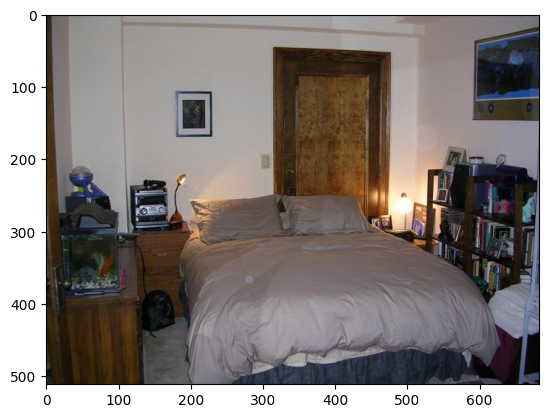

In [6]:
image_files = os.listdir(os.path.join(image_path, "training"))
image_files = [f for f in image_files if f.lower().endswith("jpg")]

first_image_file = image_files[0]
first_image_path = os.path.join(os.path.join(image_path, "training"), first_image_file)
img = Image.open(first_image_path)
plt.imshow(img)
print(f"Image format : {img.format}")
print(f"Image size : {img.size}")
print(f"Image mode : {img.mode}")

In [7]:
train_transform = A.Compose([
    # train_transform은 다양성을 위한 무작위 변환에 초점을 맞춤.
    A.Resize(height=473, width=473),
    A.PadIfNeeded(min_height=473, min_width=473, border_mode=cv2.BORDER_CONSTANT,value=0, mask_value=0),
    A.RandomCrop(height=473, width=473),

    A.HorizontalFlip(p=0.5),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),

    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(height=473, width=473),
    A.CenterCrop(height=473, width=473),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

/tmp/ipython-input-140095545.py:4: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=473, min_width=473, border_mode=cv2.BORDER_CONSTANT,value=0, mask_value=0),


In [8]:
# train_transform = transforms.Compose([
#     # train_transform은 다양성을 위한 무작위 변환에 초점을 맞춤.
#     # 224가 작다는 이야기가 있음.. 384, 473 중에서 다시 해보기
#     transforms.Resize(473),
#     transforms.RandomCrop(473, pad_if_needed=True, padding_mode='constant', fill=0),
#     transforms.RandomHorizontalFlip(p=0.5),

#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
# ])

# test_transform = transforms.Compose([
#     transforms.Resize(473),
#     transforms.CenterCrop(473),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
# ])

In [9]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mode='train', transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.mode = mode

        self.img_folder = os.path.join(self.image_dir, 'images', mode)
        self.mask_folder = os.path.join(self.image_dir, 'annotations', mode)

        self.img_files = sorted(os.listdir(self.img_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))

    def __len__ (self):
        return len(self.img_files)

    def __getitem__(self, index):
        image = Image.open(os.path.join(self.img_folder, self.img_files[index]))
        image = image.convert('RGB')
        image = np.array(image)

        mask = Image.open(os.path.join(self.mask_folder, self.mask_files[index]))
        mask = mask.convert('L')
        mask = np.array(mask)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [10]:
class TestDataset(Dataset):
    def __init__(self, image_dir, mode='test', transform=None):
        self.image_dir = image_dir
        self.transform = transform

        self.img_folder = os.path.join(self.image_dir, mode)
        self.img_files = sorted(os.listdir(self.img_folder))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, index):
        img_name = self.img_files[index]
        image_path = os.path.join(self.img_folder, img_name)
        image = Image.open(image_path).convert('RGB')

        image = np.array(image)

        if self.transform:
            augmented = self.transform(image=image)
            image=augmented['image']
        return image, img_name

In [11]:
train_dataset = CustomDataset(image_dir=os.path.join(head_path, 'ADEChallengeData2016'), mode='training', transform=train_transform)
val_dataset = CustomDataset(image_dir = os.path.join(head_path, 'ADEChallengeData2016'), mode='validation', transform=test_transform)
test_dataset = TestDataset(image_dir = os.path.join(head_path, 'release_test'), mode='testing', transform=test_transform)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

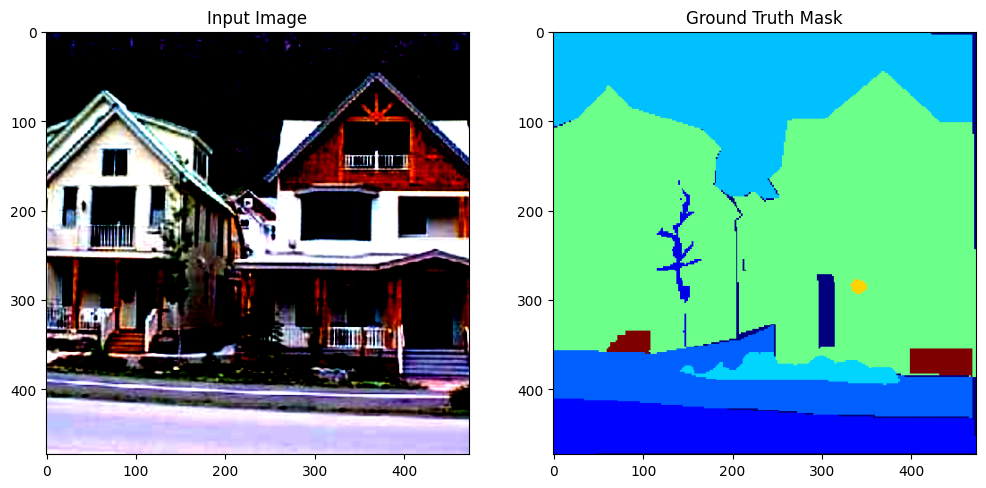

In [13]:
dataiter = iter(train_loader)
images, masks = next(dataiter)
img_tensor = images[0]
mask_tensor = masks[0]

img_show = img_tensor.permute(1, 2, 0).numpy()
mask_show = mask_tensor.squeeze().numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_show)
ax[0].set_title("Input Image")

ax[1].imshow(mask_show, cmap='jet')
ax[1].set_title("Ground Truth Mask")
plt.show()

## Backbone 모델 : ResNet50
- Classification용 ResNet 말고 Segmentation용 ResNet이 필요함
- 우리는 위치 정보가 필요하기 때문에 ResNet의 `avgpool`과 `fc`는 잘라낸다
  - `avgpool` (Global Average Pooling) : ResNet 끝에 있는 `avgpool` 은 15x15의 Feature Map을 1x1로 축소 시킴
  
  -> 위치 정보(공간 정보)는 삭제하고 사물이 있다는 요약 정보만 남김
  - `fc` (Fully Connected Layer) : 요약 정보를 가지고 확률을 계산한다.
`avgpool`을 통과하는 순간 위치 정보가 사라지기 때문에 `layer4`까지만 통과시키고, 그 결과물의 Feature Map을 그대로 가져와야 한다.

In [14]:
def get_backbone(layers):
    if layers == 50:
        weights = models.ResNet50_Weights.DEFAULT
        backbone = models.resnet50(
            weights=weights,
            replace_stride_with_dilation=[False, True, True]
        )
    elif layers == 101:
        weights = models.ResNet101_Weights.DEFAULT
        backbone = models.resnet101(
            weights=weights,
            replace_stride_with_dilation=[False, True, True]
        )

    backbone_layers = list(backbone.children())[:-2]
    backbone = nn.Sequential(*backbone_layers)

    return backbone

In [15]:
class PPM(nn.Module):
    def __init__ (self, in_channels, sizes=[1, 2, 3, 6]):
        super().__init__()
        self.stages = nn.ModuleList([])

        # Context Representation의 차원 수를 원래 특징 맵 차원의 1/N으로 줄여야 함. (N : 피라미드 레벨 수 (4))
        out_channels = int(in_channels/ len(sizes))

        for size in sizes:
            self.stages.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=(size, size)),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False), # 풀링 이후 이어지는 1x1 conv
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
    def forward(self, x):
        layers = [x]
        for stage in self.stages:
            p = stage(x)
            # Upsampling : Bilinear Interpolation 수행
            p = F.interpolate(p, size=x.shape[2:], mode='bilinear', align_corners=False)
            layers.append(p)
        return torch.cat(layers, dim=1)


In [16]:
class PSPN(nn.Module):
    def __init__(self, layers=50, classes=151): # Backbone으로 몇 층 짜리 모델을 사용할 것인가? : 50
        super().__init__()

        # Backbone
        self.backbone = get_backbone(layers)
        self.in_channels=2048 # ResNet50/101의 마지막 채널 수

        # PPM (Neck)
        # 7x7x2048 의 Feature Map을 받아서 AdaptiveAveragePool2d()로 쪼개기
        self.ppm = PPM(in_channels=self.in_channels)

        # Decoder (Head)
        # 현재 채널 : (2048 + 514*2 = 4096)
        # CrossEntropyLoss를 쓸 예정이니, 클래스 개수대로 채널 수 맞추기 (내부에서 LogSoftmax 사용)
        self.cls = nn.Sequential(
            nn.Conv2d(4096, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(512, classes, kernel_size=1)
            # Flatten 거치고 Fully-Connected Layer로 하면 안됨
            # : (x,y)의 좌표 개념이 사라져버림 -> Spatial Info 사라짐
        )

    def forward(self, x):
        x = self.backbone(x)

        x = self.ppm(x)

        x = self.cls(x)

        x = F.interpolate(x, scale_factor=8, mode='bilinear', align_corners=False)

        return x

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PSPN(layers=50, classes=151).to(device)

#optimizer = optim.Adam(model.parameters(), lr=0.001) # 논문과 동일한지 확인 필요
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=255)

max_iters=40000

scheduler = PolynomialLR(optimizer, max_iters, power=0.9)

In [18]:
def confusion_matrix(pred_mask, ground_truth, num_classes):
   # 클래스 별 IoU 계산 결과를 평균 내기
    pred_mask = torch.argmax(pred_mask, dim=1)
    pred_mask = pred_mask.cpu().numpy()
    ground_truth = ground_truth.cpu().numpy()

    pred_mask = pred_mask.flatten()
    ground_truth = ground_truth.flatten()

    # Ground Truth는 항상 0~(C-1)이 아님.
    # 우리가 분류하고자 하는 것은 21개의 클래스이니까, Ground Truth의 값들 중에서 해당 범위 내의 것만 살펴보자.
    k = (ground_truth >= 0) & (ground_truth < num_classes)

    hist = np.bincount(
        num_classes * ground_truth[k].astype(int) + pred_mask[k],
        minlength = num_classes ** 2
    ).reshape(num_classes, num_classes)


    return hist

In [19]:
def calculate_mIoU(hist):
    intersection = np.diag(hist) # 교집합 (P와 G)

    # Union = (Pred 합) + (Target 합) - Intersection
    # axis=0은 열의 합(Prediction 관점), axis=1은 행의 합(Target 관점)
    union = hist.sum(axis=1) + hist.sum(axis=0) - intersection

    iou = intersection / (union + 1e-10)
    # 1e-10을 더하는 이유 : Union 이 0인 경우 0/0 -> NaN 발생
    # 1e-10을 더하면 0/1e-10 -> NaN 대신 0을 반환

    valid_mask = union > 0
    mIoU = np.nanmean(iou[valid_mask])

    return mIoU, iou

In [20]:
def model_train(model, train_loader, optimizer, criterion, max_iters):
    model.train()
    max_iter = max_iters
    iter = 0
    scaler = GradScaler()

    while iter < max_iter:
        for images, masks in train_loader:
            images = images.cuda()
            masks = masks.cuda().long() # long type 변환 필요?

            optimizer.zero_grad()
            with autocast():
                outputs = model(images)

                if outputs.shape[-2:] != masks.shape[-2:]:
                    outputs = F.interpolate(
                        outputs,
                        size=masks.shape[-2:],
                        mode='bilinear',
                        align_corners=False
                    )

                loss = criterion(outputs, masks)
            #loss.backward()
            scaler.scale(loss).backward()

            #optimizer.step()
            scaler.step(optimizer)
            scaler.update()

            scheduler.step()

            iter+=1
            if iter % 100 == 0:
                lr_count = optimizer.param_groups[0]['lr']
                print(f"Current Iter {iter} / {max_iters} | Loss : {loss.item():.4f} | LR : {lr_count:.6f}")
            if iter >= max_iters:
                print("Training Finished.")
                break

- 배치 평균 (Batch Average) : (배치 A 점수 + 배치 B 점수) / 2
- 전체 평균 (Global Average) : (배치 A 맞은 개수 + 배치 B 맞은 개수) / (배치 A 전체 + 배치 B 전체)

**데이터마다 클래스 등장 빈도가 다르기 때문에, Matrix를 다 더한 다음에 나눠야 함.**

In [21]:
def model_val(model, val_loader, num_classes, device):
    model.eval()

    total_hist = np.zeros((num_classes, num_classes))

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            with autocast():
                outputs = model(images)
            curr_hist = confusion_matrix(outputs, masks, num_classes)
            total_hist += curr_hist


    final_mIoU, class_IoU = calculate_mIoU(total_hist)
    print(f"Validation Score : {final_mIoU}")
    return final_mIoU

In [22]:
def model_test(model, test_loader, num_classes, device):
    model.eval()
    all_outputs = []
    all_img_names = []

    total_hist = np.zeros((num_classes, num_classes))
    with torch.no_grad():
        for images, masks, img_names in tqdm(test_loader):
            images, masks = images.to(device), masks.to(device)

            with autocast():
                outputs = model(images)

            curr_hist = confusion_matrix(outputs, masks, num_classes)
            total_hist += curr_hist

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            for i in range(len(images)):
                all_outputs.append(preds[i])
                all_img_names.append(img_names[i])

    final_mIoU, class_IoU = calculate_mIoU(total_hist)
    print(f"Test Score : {final_mIoU}")

    return final_mIoU, all_outputs, all_img_names

In [23]:
images, masks = next(iter(train_loader))
print(f"Mask Min value : {masks.min()}")
print(f"Mask Max value : {masks.max()}")
print(f"Unique Values : {torch.unique(masks)}")

Mask Min value : 0
Mask Max value : 138
Unique Values : tensor([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,  11,  13,  14,  15,
         16,  18,  19,  20,  21,  23,  27,  28,  29,  31,  33,  36,  37,  45,
         47,  48,  51,  64,  67,  74,  83,  86,  90,  93,  99, 113, 119, 126,
        130, 134, 136, 138], dtype=torch.uint8)


In [24]:
num_classes = 151

# Train the model
print("Starting model training...")
model_train(model, train_loader, optimizer, criterion, max_iters)
print("Model training complete.")

Starting model training...


/tmp/ipython-input-3491307872.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-3491307872.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Current Iter 100 / 40000 | Loss : 2.3715 | LR : 0.009977
Current Iter 200 / 40000 | Loss : 1.5542 | LR : 0.009955
Current Iter 300 / 40000 | Loss : 1.9008 | LR : 0.009932
Current Iter 400 / 40000 | Loss : 2.3243 | LR : 0.009910
Current Iter 500 / 40000 | Loss : 1.8703 | LR : 0.009887
Current Iter 600 / 40000 | Loss : 1.6049 | LR : 0.009865
Current Iter 700 / 40000 | Loss : 1.6019 | LR : 0.009842
Current Iter 800 / 40000 | Loss : 1.4264 | LR : 0.009820
Current Iter 900 / 40000 | Loss : 1.3102 | LR : 0.009797
Current Iter 1000 / 40000 | Loss : 1.2275 | LR : 0.009775
Current Iter 1100 / 40000 | Loss : 1.2480 | LR : 0.009752
Current Iter 1200 / 40000 | Loss : 1.4238 | LR : 0.009730
Current Iter 1300 / 40000 | Loss : 1.0844 | LR : 0.009707
Current Iter 1400 / 40000 | Loss : 1.1966 | LR : 0.009684
Current Iter 1500 / 40000 | Loss : 1.4841 | LR : 0.009662
Current Iter 1600 / 40000 | Loss : 1.4959 | LR : 0.009639
Current Iter 1700 / 40000 | Loss : 1.3326 | LR : 0.009617
Current Iter 1800 / 400

KeyboardInterrupt: 

In [ ]:
# Validate the model
print("Starting model validation...")
validation_miou = model_val(model, val_loader, num_classes)
print(f"Validation mIoU: {validation_miou:.4f}")
print("Model validation complete.")

In [ ]:
# Test the model
print("Starting model testing...")
test_miou, all_outputs, all_img_names = model_test(model, test_loader, num_classes)
print(f"Test mIoU: {test_miou:.4f}")
print("Model testing complete.")